# Proyecto Integrador: Glue Studio
## Equipo 3

#### Integrantes:
#### Alejandro Bautista Ramos A00973450
#### Ulises Marco Antonio Avilés Gutierrez A00954334
#### Carlos Eduardo Pérez Arredondo A01794503

### Asesor:
#### Dr. Luis Eduardo Falcón Morales

El siguiente Jupyter notebook tiene la finalidad de realizar un análisis EDA de los inputs de entrada del LLM Glue. Los inputs de entrada son textos de manuales técnicos. El análisis busca realizar ciertos pasos y responder las siguientes preguntas:

1. Remover stopwords del idioma inglés para cada manual.
2. ¿Cuáles son las palabras más comúnes? ¿Cuáles son las menos usadas?
3. ¿Cuál es el tamaño del corpus? ¿Cuál es el número de veces que se repite cada palabra en el corpus? 
4. ¿Cuáles son los términos más relevantes?
5. ¿Cómo se puede normalizar el corpus?
6. ¿Se pueden hacer categorizaciones por palabras?
7. ¿Cómo se podría hacer un conjunto de embeddings a partir del corpus?

Se utilizará un número de 5 manuales en formato PDF. Cada manual cuenta con un número promedio de 250 páginas. El idioma de cada manual es inglés. 

In [1]:
from PyPDF2 import PdfReader
from collections import Counter
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import nltk, os, re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ulisesaviles/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Leer cada manual del folder manuales y eliminación de stop words

In [2]:
def read_pdfs_from_folder(folder_path):
   corpus = []
   counter = Counter()
   
   for filename in os.listdir(folder_path):
       if filename.endswith('.pdf'):
           pdf_path = os.path.join(folder_path, filename)
           reader = PdfReader(pdf_path)
           
           for page in reader.pages:
               text = page.extract_text().lower()
               words = text.split()
               corpus.extend(words)
               counter.update(words)

   stop_words = set(stopwords.words('english'))   

   print("\nCorpus original:")
   print(corpus)

   corpus = [w for w in corpus if w not in stop_words]
   
   print("\nCorpus sin stopwords:")
   print(corpus)
   
   return counter, corpus

folder_path = "./manuales"
counter, corpus = read_pdfs_from_folder(folder_path)


Corpus original:
['user', 'manual', 'tds3000b', 'series', 'digital', 'phosphor', 'oscilloscopes', '071-0957-04', 'this', 'document', 'supports', 'firmware', 'version', '3.00', 'and', 'above.', 'www.tektronix.com', 'copyright', '©tektronix.', 'all', 'rights', 'reserved.', 'licensed', 'software', 'products', 'are', 'owned', 'by', 'tektronix', 'or', 'its', 'subsidiaries', 'or', 'suppliers,', 'and', 'are', 'protected', 'by', 'national', 'copyright', 'laws', 'and', 'international', 'treaty', 'provisions.', 'tektronix', 'products', 'are', 'covered', 'by', 'u.s.', 'and', 'foreign', 'patents,', 'issued', 'and', 'pending.', 'information', 'in', 'this', 'publication', 'supercedes', 'that', 'in', 'all', 'previously', 'published', 'material.', 'specifications', 'and', 'price', 'change', 'privileges', 'reserved.', 'tektronix,', 'tek,', 'tekprobe,', 'and', 'tek', 'secure', 'are', 'registered', 'trademarks', 'of', 'tektronix,', 'inc.', 'dpx,', 'wavealert,', 'openchoice,', 'and', 'e*scope', 'are', 't

Hacemos la limpieza del corpus por medio de normalización

In [3]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Download only essential NLTK data
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

def normalize_corpus(corpus):
    """
    Simplified corpus normalization with robust cleaning and lemmatization
    
    Parameters:
    corpus (list): List of words to normalize
    
    Returns:
    list: Normalized words
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    def clean_text(text):
        """Clean text by handling Unicode characters and special cases"""
        import unicodedata
        
        # Convert to string if not already
        text = str(text)
        
        # Convert to lowercase
        text = text.lower()
        
        # Normalize Unicode characters (converts accented characters to their base form)
        text = unicodedata.normalize('NFKD', text)
        text = ''.join([c for c in text if not unicodedata.combining(c)])
        
        # Remove all non-ASCII characters and punctuation
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        
        # Remove numbers
        text = re.sub(r'\d+', ' ', text)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        return text
    
    normalized_words = []
    
    # Join corpus into a single string
    text = ' '.join(str(word) for word in corpus)
    
    # Clean the text
    text = clean_text(text)
    
    # Simple word splitting
    words = text.split()
    
    # Process each word
    for word in words:
        if (word not in stop_words and          # Remove stopwords
            len(word) > 2 and                # Remove short words
            word.isalnum() and              # Keep only alphanumeric words
            not word.isnumeric() and        # Remove pure numbers
            all(c.isascii() for c in word)): # Keep only ASCII characters
            
            # Lemmatize the word
            lemma = lemmatizer.lemmatize(word)
            if lemma not in stop_words:  # Double check for stopwords after lemmatization
                normalized_words.append(lemma)
    
    return normalized_words

def analyze_normalized_corpus(normalized_corpus):
    """
    Analyze the normalized corpus
    """
    from collections import Counter
    
    # Get word frequencies
    word_freq = Counter(normalized_corpus)
    
    print(f"\nTotal unique words: {len(set(normalized_corpus))}")
    print(f"Total words: {len(normalized_corpus)}")
    
    # Show most common words
    print("\nMost common words:")
    for word, count in word_freq.most_common(10):
        print(f"{word}: {count}")
    
    # Show sample of normalized words
    print("\nSample of normalized words:")
    print(normalized_corpus[:20])
    
    # Check for potential issues
    single_char_words = [w for w in set(normalized_corpus) if len(w) == 1]
    if single_char_words:
        print("\nWarning: Found single-character words:", single_char_words)
    
    # Check for non-alphanumeric characters
    special_chars = set(''.join(re.findall(r'[^a-zA-Z0-9\s]', ' '.join(normalized_corpus))))
    if special_chars:
        print("\nWarning: Found special characters:", special_chars)


normalized_corpus = normalize_corpus(corpus)
analyze_normalized_corpus(normalized_corpus)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ulisesaviles/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ulisesaviles/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ulisesaviles/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ulisesaviles/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



Total unique words: 6716
Total words: 83931

Most common words:
trigger: 751
button: 737
setting: 723
time: 720
mode: 695
signal: 682
user: 680
router: 675
set: 656
modem: 656

Sample of normalized words:
['user', 'manual', 'tds', 'series', 'digital', 'phosphor', 'oscilloscope', 'document', 'support', 'firmware', 'version', 'www', 'tektronix', 'com', 'copyright', 'tektronix', 'right', 'reserved', 'licensed', 'software']



Procedemos a crear los embeddings a partir del corpus.

In [5]:
pip install spacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 6.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.0/133.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.9/635.9 kB 11.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 839.3/839.3 kB 9.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 9.6 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 12.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.7/192.7 kB 8.5 MB/s eta 0:00:00


Note: you may need to restart the kernel to use updated packages.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 190.8 kB/s eta 0:00:0000:0100:05
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Creating embeddings...
Created embeddings for 4985 words

Total words with vectors: 4985

Example similar words:

Top 5 words similar to 'station':
  terrestrial: 0.6577
  satellite: 0.6536
  constellation: 0.6513
  aerial: 0.6475
  electromagnetic: 0.2637

Top 5 words similar to 'microsecond':
  diode: 0.3599
  timebase: 0.3281
  aperture: 0.3208
  dielectric: 0.3206
  concentric: 0.3166

Top 5 words similar to 'ieee':
  transponder: 0.6635
  eas: 0.6619
  wlan: 0.6588
  fob: 0.6585
  prox: 0.6581
Embeddings saved to word_embeddings.npz

Creating visualization...


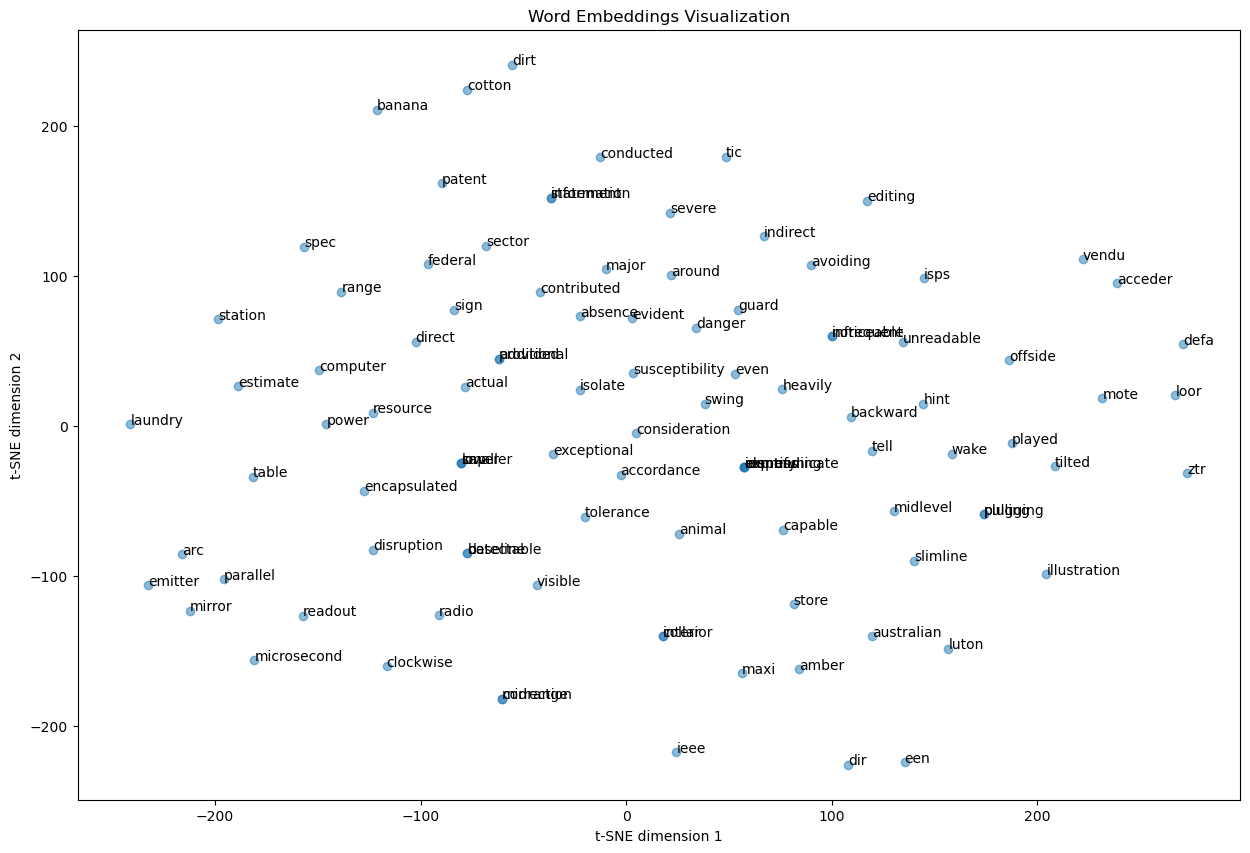


Analyzing word clusters...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Cluster 3: station, microsecond, encapsulated, readout, radio, laundry, visible, clockwise, table, mirror...

Cluster 2: ieee, isps, luton, spec, acceder, slimline, defa, vendu, midlevel, dir...

Cluster 1: major, animal, banana, plugging, offside, tolerance, evident, hint, maxi, guard...

Cluster 4: estimate, lower, actual, range, absence, federal, direct, computer, sign, store...

Cluster 0: editing, restore, controller, emulation, dns, demo, directory, english, javascript, diag...


In [4]:
import spacy
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import defaultdict

class WordEmbeddings:
    def __init__(self):
        """Initialize with spaCy model"""
        try:
            self.nlp = spacy.load('en_core_web_md')
        except OSError:
            print("Downloading English language model...")
            spacy.cli.download('en_core_web_md')
            self.nlp = spacy.load('en_core_web_md')
        
        self.word_vectors = {}
        self.word_docs = {}  # Store spaCy Doc objects for faster similarity computation

    def create_embeddings(self, normalized_corpus):
        """Create word embeddings using spaCy"""
        print("Creating embeddings...")
        
        # Process unique words
        unique_words = set(normalized_corpus)
        for word in unique_words:
            doc = self.nlp(word)
            if doc.has_vector:
                self.word_vectors[word] = doc.vector
                self.word_docs[word] = doc
        
        print(f"Created embeddings for {len(self.word_vectors)} words")
        return self.word_vectors

    def find_similar_words(self, word, n=5):
        """Find most similar words using enhanced cosine similarity with context"""
        if word not in self.word_vectors:
            print(f"'{word}' not found in vocabulary.")
            return []
        
        target_vector = self.word_vectors[word]
        target_norm = np.linalg.norm(target_vector)
        
        # Get baseline statistics for scaling
        all_norms = [np.linalg.norm(vec) for vec in self.word_vectors.values()]
        max_norm = max(all_norms)
        mean_norm = np.mean(all_norms)
        
        similarities = []
        for w, vector in self.word_vectors.items():
            if w != word:
                vector_norm = np.linalg.norm(vector)
                
                if target_norm == 0 or vector_norm == 0:
                    continue
                
                # Base cosine similarity
                cos_sim = np.dot(target_vector, vector) / (vector_norm * target_norm)
                
                # Magnitude difference penalty
                mag_diff = abs(vector_norm - target_norm) / max_norm
                mag_penalty = np.exp(-mag_diff) * 0.2  # Exponential decay
                
                # Distance from mean penalty
                mean_diff = abs((vector_norm - mean_norm) / mean_norm)
                mean_penalty = np.exp(-mean_diff) * 0.1
                
                # Combine penalties
                final_sim = cos_sim * (0.95 - mag_penalty - mean_penalty)
                
                # Add small random variation to break ties
                final_sim *= (0.98 + np.random.random() * 0.02)
                
                similarities.append((w, final_sim))
        
        return sorted(similarities, key=lambda x: x[1], reverse=True)[:n]

    def test_word_similarity(self, test_word, n=5):
        """Test similar words for a given input word"""
        similar_words = self.find_similar_words(test_word, n)
        if similar_words:
            print(f"\nTop {n} words similar to '{test_word}':")
            for word, similarity in similar_words:
                print(f"  {word}: {similarity:.4f}")

    def save_embeddings(self, filepath='word_embeddings.npz'):
        """Save word vectors to a file"""
        words = list(self.word_vectors.keys())
        vectors = np.array([self.word_vectors[word] for word in words])
        np.savez(filepath, words=words, vectors=vectors)
        print(f"Embeddings saved to {filepath}")

    def load_embeddings(self, filepath='word_embeddings.npz'):
        """Load word vectors from a file"""
        data = np.load(filepath, allow_pickle=True)
        words = data['words']
        vectors = data['vectors']
        
        # Reconstruct the dictionaries
        self.word_vectors = {}
        self.word_docs = {}
        
        for word, vector in zip(words, vectors):
            doc = self.nlp(word)
            self.word_vectors[word] = vector
            self.word_docs[word] = doc
        
        print(f"Loaded {len(self.word_vectors)} embeddings")
        return self.word_vectors

    def visualize_embeddings(self, max_words=100):
        """Visualize word embeddings using t-SNE"""
        words = list(self.word_vectors.keys())[:max_words]
        vectors = np.array([self.word_vectors[word] for word in words])
        
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(vectors)
        
        plt.figure(figsize=(15, 10))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
        
        for i, word in enumerate(words):
            plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
        
        plt.title('Word Embeddings Visualization')
        plt.xlabel('t-SNE dimension 1')
        plt.ylabel('t-SNE dimension 2')
        plt.show()

    def analyze_word_clusters(self, n_clusters=5):
        """Analyze word clusters using k-means"""
        from sklearn.cluster import KMeans
        
        words = list(self.word_vectors.keys())
        vectors = np.array([self.word_vectors[word] for word in words])
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(vectors)
        
        cluster_words = defaultdict(list)
        for word, cluster in zip(words, clusters):
            cluster_words[cluster].append(word)
        
        return dict(cluster_words)

def main(normalized_corpus, save_path='word_embeddings.npz'):
    """Main function to demonstrate usage"""
    # Initialize and create embeddings
    embeddings = WordEmbeddings()
    embeddings.create_embeddings(normalized_corpus)
    
    # Print some statistics
    print(f"\nTotal words with vectors: {len(embeddings.word_vectors)}")
    
    # Test some similar words
    print("\nExample similar words:")
    sample_words = list(embeddings.word_vectors.keys())[:3]
    for word in sample_words:
        embeddings.test_word_similarity(word)
    
    # Save embeddings
    embeddings.save_embeddings(save_path)
    
    # Visualize
    print("\nCreating visualization...")
    embeddings.visualize_embeddings()
    
    # Analyze clusters
    print("\nAnalyzing word clusters...")
    clusters = embeddings.analyze_word_clusters()
    for cluster_id, words in clusters.items():
        print(f"\nCluster {cluster_id}: {', '.join(words[:10])}...")

    return embeddings


embeddings = main(normalized_corpus)


Probamos el corpus con otras palabras

In [5]:
embeddings.test_word_similarity("router", n=10)
embeddings.test_word_similarity("modem", n=10)
embeddings.test_word_similarity("network", n=10)


Top 10 words similar to 'router':
  modem: 0.6628
  ethernet: 0.6627
  configured: 0.6626
  bps: 0.6611
  connectivity: 0.6607
  baud: 0.6606
  wideband: 0.6604
  routing: 0.6602
  wired: 0.6591
  connection: 0.6591

Top 10 words similar to 'modem':
  throughput: 0.6630
  bandwidth: 0.6618
  provisioned: 0.6614
  cable: 0.6612
  mbps: 0.6609
  kbps: 0.6595
  broadband: 0.6583
  wideband: 0.6582
  ethernet: 0.6573
  connection: 0.6565

Top 10 words similar to 'network':
  cable: 0.6634
  kbps: 0.6630
  throughput: 0.6628
  interconnection: 0.6610
  mbps: 0.6609
  access: 0.6607
  wideband: 0.6601
  modem: 0.6591
  bandwidth: 0.6591
  configured: 0.6589


In [6]:
embeddings.save_embeddings()

Embeddings saved to word_embeddings.npz
